# Zillow3 - prices

This code explores house prices for different tiers.

In [1]:
import pandas as pd
import os
#import re
import string
import plotly
import plotly.express as px
#import numpy as np
#from IPython.display import HTML, display

In [2]:
# add save image function
%run ../../aid/save_image_plotly.ipynb

Function available: save_plotly(figure, filename)


In [3]:
# add time series clean function
%run functions/clean_TS.ipynb

Function clean_TS(dataframe, value_name) available. Chose a value_name of your preference: 'index', 'price', 'Zri'...


In [4]:
# load data
%run Zillow1_loaddata.ipynb

Function: load_zillow(geography ,tenure=all). geography=('state'/'county'), tenure=('rentals'/'prices'/'all')


In [5]:
load_zillow('state', 'prices')

S_Zhvi_All ../input/zhvi/State_Zhvi_AllHomes.csv
S_Zhvi_SFR ../input/zhvi/State_Zhvi_SingleFamilyResidence.csv
S_Zhvi_Bot ../input/zhvi/State_Zhvi_BottomTier.csv
S_Zhvi_Top ../input/zhvi/State_Zhvi_TopTier.csv


In [6]:
# raw data is in this folder on subdirectories
input_folder = '../input'

----------
## House Prices

In [7]:
S_Zhvi_All.head(3)

RegionID  SizeRank  RegionName RegionType StateName  1996-01-31  \
0         9         0  California      State        CA    162238.0   
1        54         1       Texas      State        TX     97631.0   
2        43         2    New York      State        NY    139108.0   

   1996-02-29  1996-03-31  1996-04-30  1996-05-31  ...  2019-06-30  \
0    162008.0    161859.0    161569.0    161373.0  ...    555305.0   
1     97656.0     97684.0     97811.0     97948.0  ...    206423.0   
2    138793.0    138607.0    138327.0    138224.0  ...    323518.0   

   2019-07-31  2019-08-31  2019-09-30  2019-10-31  2019-11-30  2019-12-31  \
0    556199.0    557569.0    559490.0    561495.0    563523.0    566433.0   
1    207079.0    207699.0    208380.0    208865.0    209358.0    209723.0   
2    324039.0    324498.0    324903.0    325371.0    325925.0    326646.0   

   2020-01-31  2020-02-29  2020-03-31  
0    569813.0    573975.0    578267.0  
1    210164.0    210591.0    211199.0  
2    327360.0    328101.0    328677.0  

[3 rows x 296 columns]

In [8]:
# house prices all homes
last_date = S_Zhvi_All.columns[-1] # only last item on columns names
df = S_Zhvi_All[['RegionName', 'StateName', last_date]]
df.columns = ['State', 'abb', 'price']

In [9]:
fig_map_prices = px.choropleth(df, locationmode="USA-states", 
                    scope="usa",
                    color="price",
                    locations="abb", 
                    featureidkey="properties.district",
                    title='House Prices <br>  %s' %last_date,
                    hover_name = 'State',
                    width=800, height=500,
                    color_continuous_scale='ylgnbu',
                    range_color=[df['price'].min(), df['price'].max()] # set the range color to mach min and maximum prices
                   )
#save_plotly(fig_map_prices, 'map_prices_S.png')
fig_map_prices.show()

## Price across time

Lets see how prices varied on the cross section...Was CA always that expensive when compared to other states?

In [11]:
## this snipet save plots as png, later I crop and insert them as picture

## list of dates to plot
col = [-1 - (12*4*i) for i in range(7)] # columns every 4 years from last date
col.reverse()
dates_to_plot = [S_Zhvi_All.columns[i] for i in  col]

## color range to plot - all maps will share same scale
min_range = S_Zhvi_All[dates_to_plot].min().min()
max_range = S_Zhvi_All[dates_to_plot].max().max()

## loop dates to plot
for last_date in dates_to_plot:
    df = S_Zhvi_All[['RegionName', 'StateName', last_date]]
    df.columns = ['State', 'abb', 'price']
    
    fig_map_prices = px.choropleth(df, locationmode="USA-states", 
                        scope="usa",
                        color="price",
                        locations="abb", 
                        featureidkey="properties.district",
                        title='&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; %s' %last_date[:4],
                        hover_name = 'State',
                        width=800, height=500,
                        color_continuous_scale='ylgnbu',
                        range_color=[min_range, max_range], # set the range color to mach min and maximum prices
                        )
    fig_map_prices.layout.update(
    font=dict(
        #family="Courier New, monospace",
        size=18))
    
    # diferent names to save each map
    f_name = '../images/f_' + last_date[:4] + '.png'
    
    #save_plotly(fig_map_prices, f_name)
    #fig_map_prices.show()

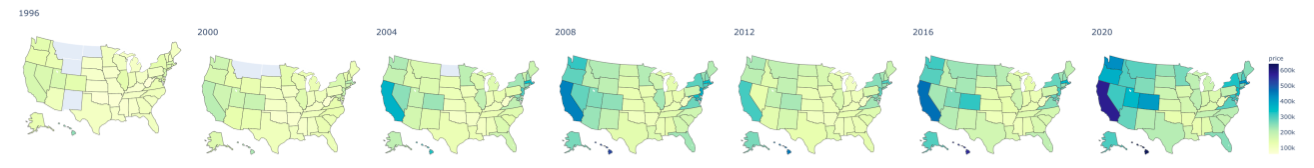

### Compare price dynamics for different tiers - level

In [12]:
def df_cat(dfx, category):
    '''cleans TS (long format) and add categorical column'''
    
    df  = clean_TS(dfx, 'price')
    df['category'] = category
    return df

In [13]:
# concatenate long form of all tables, with categories
price_all_tiers = pd.concat([df_cat(S_Zhvi_Top, 'top'),
                             df_cat(S_Zhvi_All, 'mid'),
                             df_cat(S_Zhvi_Bot, 'bottom'),
                             df_cat(S_Zhvi_SFR, 'SFR')]).reset_index(drop=True)

In [14]:
fig = px.line(price_all_tiers.sort_values(by=['RegionName', 'Date']),
              x="Date", 
              y="price",
              color='category',
              facet_col='RegionName', 
              facet_col_wrap=8,
              title='House Prices - tiers',
              template="plotly_white",
              labels= {'RegionName':'',
                       'price':'',
                       'Date':''},
              color_discrete_sequence=px.colors.qualitative.Set2,
              height=1000)
fig.show()

Observations of the plots above:
- Single family homes prices are approximatelly the same as the mid range.
- Note the states with boom/bust in 2007-09, and the ones with prices almost flat.

### Compare price dynamics for different tiers - Index

### States by price segments

In [16]:
## find blocks of 5 states: most expensive, mid range, least expensive

df = price_all_tiers

# list of states from least to most expensive
states_ord_price = (df[(df.Date==df.Date.max()) & (df.category=='mid')]. # filter most recent and mid prices
                    sort_values(by='price',ascending=False). # order by rental index
                    loc[:,'RegionName'] )  # only states names selected

In [17]:
top = df[df.RegionName.isin (states_ord_price[:5])]
mid = df[df.RegionName.isin (states_ord_price[23:28])]
bot = df[df.RegionName.isin (states_ord_price[-5:])]

In [19]:
def fig_tier(dfx, tier):
    
    fig = (px.line(dfx.sort_values(by=['RegionName', 'Date']),
              x="Date", 
              y="price",
              color='category',
              facet_col='RegionName', 
              title='House Prices - %s range states' %tier,
              template="plotly_white",
              color_discrete_sequence=px.colors.qualitative.Set2,
              labels= {'RegionName':'',
                       'price':'',
                       'Date':''},
              height=350
             ))
    return fig

In [20]:
fig_tier(top, 'top').show()
fig_tier(mid, 'mid').show()
fig_tier(bot, 'bottom').show()